In [1]:
from scipy.io import netcdf, loadmat
import numpy as np
from pylab import clf, plot, show, floor, ceil, imshow
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#xlabel, ylabel, legend, savefig, colorbar, title, clim, pcolor, cm, contourf
import os
import csv
import sys
import glob
from IPython.display import display, Math, Latex
from python_functions import *

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
nx = 420
ny = 384

In [3]:
dHdx, dHdy = BathyGrad(18,True)

# Calculating matrix:
#  (-1 0 1 . . . . . 0 0 0 )
#  (0 -1 0 1 . . . . . . 0 )
#  (0 0 -1 0 1 . . . 0 0 0 )
#  .........
#  (0 0 0 0 0 0 0 0 -1 0 1 )

id_y = np.zeros([ny,ny])
id_y[0,0:2] = [0,1]
id_y[1,0:3] = [-1,0,1]
id_y[ny-2,ny-3:ny] = [-1,0,1]
id_y[ny-1,ny-1:ny] = -1
for i in range(2,ny-2):
    id_y[i,i-1:i+2] = [-1,0,1]
    
# Calculating matrix:
#  (-1 0 0 . . . . . 0 0 0 )
#  (0 -1 0 1 . . . . . . 0 )
#  (1 0 -1 0 1 . . . 0 0 0 )
#  (0 1 0  .....     0 0 0 )
#  ( . . . . . . . . . )
#  (0 0 1 0 0 0 0 0 0 0 1 )

id_x = np.zeros([nx,nx])
id_x[0:2,0] = [0,1]
id_x[0:3,1] = [-1,0,1]
id_x[nx-3:nx,nx-2] = [-1,0,1]
id_x[nx-1,nx-3:nx-1] = [-1,0]
for i in range(2,nx-2):
    id_x[i-1:i+2,i] = [-1,0,1]

In [6]:
res = 18
if res == 18:
    file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results18km/grid.nc",'r')
elif res == 36:
    file2read = netcdf.NetCDFFile("/scratch/general/am8e13/results36km/grid.nc",'r')
Depth = file2read.variables['Depth']
Depth = Depth[:]*1
hfacc=file2read.variables['HFacC']
hfacc=hfacc[:]*1
dxF = file2read.variables['dxF']
dxF = dxF[:]*1
dyF = file2read.variables['dyF']
dyF = dyF[:]*1
X = file2read.variables['X']
X = X[:]*1
Y = file2read.variables['Y']
Y = Y[:]*1
Z = file2read.variables['Z']
Z = Z[:]*1

In [7]:
def grad_calc(Depth):
    Sx = np.zeros_like(hfacc[0,:,:])
    Sy = np.zeros_like(hfacc[0,:,:])
    for x in range(len(X)-1)[1:]:
        for y in range(len(Y)-1)[1:]:
            if x == 0 and y == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dyF[1,x]-dyF[1,x])
            elif x == 0 and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == (len(X)-1) and y == 0:
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[0,x])/(dyF[y+1,x]-dyF[0,x])
            elif x == (len(X)-1) and y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif x == 0:
                Sx[y,x] = -(Depth[y,1]-Depth[y,0])/(dxF[y,1]-dxF[y,0])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif x == (len(X)-1):
                Sx[y,x] = -(Depth[y,(len(X)-1)]-Depth[y,x-1])/(dxF[y,(len(X)-1)]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
            elif y == 0:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[1,x]-Depth[0,x])/(dxF[1,x]-dxF[0,x])
            elif y == (len(Y)-1):
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[(len(Y)-1),x]-Depth[y-1,x])/(dyF[(len(Y)-1),x]-dyF[y-1,x])
            elif res == 36 and y == 69:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+2,x]-dyF[y,x])
            else:
                Sx[y,x] = -(Depth[y,x+1]-Depth[y,x-1])/(dxF[y,x+1]-dxF[y,x-1])
                Sy[y,x] = -(Depth[y+1,x]-Depth[y-1,x])/(dyF[y+1,x]-dyF[y-1,x])
                
    return Sx,Sy
Sx,Sy = grad_calc(Depth)

In [8]:
dt = 600
dx = 36000
dy = 36000

In [9]:
S0 = np.zeros_like(dHdx)
S0[67*2:83*2,34*2:42*2] = 10

In [10]:
U = np.zeros_like(S0)
U[:,:] = 10
V = np.zeros_like(S0)
V[:,:] = 0

In [11]:
S = np.array(S0)
for i in range(0,200):
    S = dt*S + dt*dHdy*id_x.dot(S.T).T /(2*dx)+ dt*dHdx*id_y.dot(S)/(2*dy)

In [12]:
S = np.array(S0)
for i in range(0,200):
    S = dt*S + dt*U*id_x.dot(S.T).T /(2*dx)+ dt*V*id_y.dot(S)/(2*dy)

In [13]:
S = np.array(S0)
for i in range(0,30):
    Sx,Sy = grad_calc(S)
    S = dt*S + dt*U*Sx+ dt*V*Sy

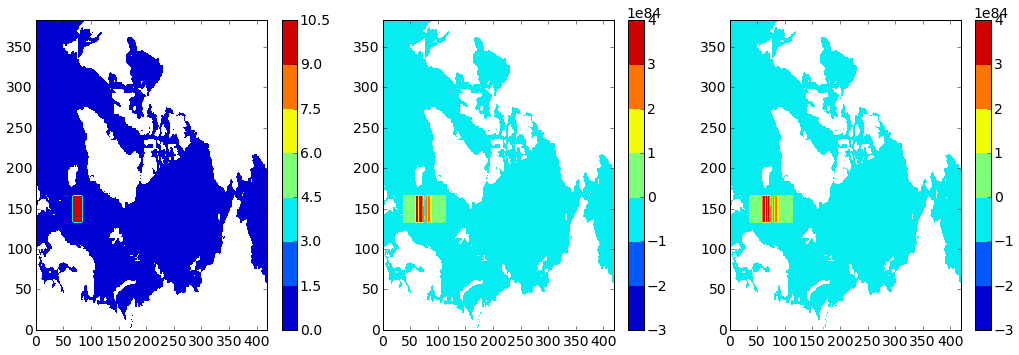

In [14]:
S[hfacc[0,:,:]==0]=np.nan
S00 = np.array(S0)
S00[hfacc[0,:,:]==0]=np.nan
fig, axes = plt.subplots(1,3)
a0 = axes[0].contourf(S00)
cbar = fig.colorbar(a0 , ax=axes[0])
a1 = axes[1].contourf(S)
cbar = fig.colorbar(a1 , ax=axes[1])
a2 = axes[2].contourf(S-S00)
cbar = fig.colorbar(a2 , ax=axes[2])
fig.subplots_adjust(right=2.4,top=1.2)

In [15]:
def nangrid(field,res):
    ### This script fills the field with nans in the right bit
    if res == 18:
        x="/scratch/general/am8e13/results18km/"        
        nx = 420
        ny = 384 
    elif res == 36:
        x="/scratch/general/am8e13/results36km/"
        nx = 210
        ny = 192
    file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
    hfacc = file2read.variables['HFacC']
    hfacc = hfacc[:]*1
    
    if len(field.shape) == 4 :
        field[:,hfacc == 0] = np.nan
    elif len(field.shape) == 3 :
        field[hfacc == 0] = np.nan
    elif len(field.shape) == 2 :
        field[hfacc[0,:,:] == 0] = np.nan
    
    return field

In [16]:
x="/scratch/general/am8e13/results18km/"        
file2read = netcdf.NetCDFFile(x+"grid.nc",'r')
hfacc = file2read.variables['HFacC']
hfacc = hfacc[:]*1

In [ ]:
## 1 D version of the advection equation